# Performance Comparison 2D and 3D Autoencoder

### Script shows basic performance metrics for the trained 2D and 3D models. 

Import Libraries

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from lf_util import *
from keras.models import Model, load_model
import glob
import cv2
from matplotlib import pyplot as plt

from skimage import data, img_as_float
from skimage.measure import compare_ssim 

import warnings
warnings.filterwarnings(action='once')

import scipy

/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/sci/anaconda2/envs/autoencoder/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Function definitions

In [3]:
def decode_2DLF(light_field4D, model2D):
    (k, l, _, _) = light_field4D.shape
    test_slices2D = np.reshape(light_field4D, (k,l,196, 1))
    test_slices2D = np.transpose(test_slices2D, (2,0,1,3))    
    decoded_slices2D = model2D.predict(test_slices2D, batch_size = 16)
    decoded2D_img4D = np.transpose(decoded_slices2D, (1,2,0,3))
    decoded2D_img4D = np.reshape(decoded2D_img4D, (k,l,14,14))
    return decoded2D_img4D

In [4]:
def decode_3DLF(light_field4D, model3D):
    test_slices3D = np.transpose(light_field4D, (2,0,1,3))
    test_slices3D = np.reshape(test_slices3D, test_slices3D.shape + (1,))
    decoded_slices3D = model3D.predict(test_slices3D, batch_size = 1)
    decoded3D_img4D = np.squeeze(decoded_slices3D)
    decoded3D_img4D = np.transpose(decoded3D_img4D, (1,2,0,3))
    return decoded3D_img4D

In [5]:
def plot_LF(title, light_field4d, view1, view2, gamma):
    fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
    img1_2D = np.power(light_field4d[:,:,view1[0],view1[1]], gamma)
    img2_2D = light_field4d[:,:,view2[0],view2[1]]
    plt.subplot(121)
    plt.title(title + ': View 1')
    plt.imshow(img1_2D, cmap='gray')
    plt.subplot(122)
    plt.title(title +': View 2')
    plt.imshow(img2_2D, cmap='gray')

In [6]:
def plot_graph(sigma, mse, label='MSE', figsize=(10,6)):
    fig = plt.figure(figsize=figsize, dpi= 100, facecolor='w', edgecolor='k')
    plt.loglog(sigma,  mse[0], marker='o', label='Noisy Image')
    plt.loglog(sigma,  mse[1], marker='o', label='14 - AVG ')
    plt.loglog(sigma,  mse[2], marker='o', label='2D CNN')
    plt.loglog(sigma,  mse[3], marker='o', label='3D CNN')
    plt.legend()
    plt.grid(which='both')
    #plt.xlabel("Noise standard deviation")
    #plt.ylabel(label + " in Percent")

In [7]:
def get_err_over_noise(sigma, test_img4D, model2D, model3D, method = 'mse'):

    if method == 'mse':
        mse = [[] for i in range(4)]

        for i, sig in enumerate(sigma):

            print("%d / %d noise levels calculated" % (i, len(sigma)), end='\r')

            # encode, decode, and avergae noisy images
            noise_array = np.ndarray(shape=test_img4D.shape)
            noisy_img = np.clip(test_img4D + cv2.randn(noise_array, 0, sig), 0, 1)
            dec2D = decode_2DLF(noisy_img, model2D)
            dec3D = decode_3DLF(noisy_img, model3D)
            avg_img = np.mean(noisy_img, 2)
            avg_img = np.tile(avg_img, (14,1,1,1))
            avg_img = np.transpose(avg_img, (1,2,0,3))


            # calculate mean squared errors
            mse[0].append(np.mean((test_img4D - noisy_img)**2)*100)
            mse[1].append(np.mean((test_img4D - avg_img)**2)*100)
            mse[2].append(np.mean((test_img4D - dec2D)**2)*100)
            mse[3].append(np.mean((test_img4D - dec3D)**2)*100)

        print("%d / %d noise levels calculated" % (len(sigma), len(sigma)), end='\r')
        return mse
    
    elif method == 'ssim':
        ssim = [[] for i in range(4)]

        for i, sig in enumerate(sigma):

            print("%d / %d noise levels calculated" % (i, len(sigma)), end='\r')

            # encode, decode, and avergae noisy images
            noise_array = np.ndarray(shape=test_img4D.shape)
            noisy_img = np.clip(test_img4D + cv2.randn(noise_array, 0, sig), 0, 1)
            dec2D = decode_2DLF(noisy_img, model2D)
            dec3D = decode_3DLF(noisy_img, model3D)
            avg_img = np.mean(noisy_img, 2)
            avg_img = np.tile(avg_img, (14,1,1,1))
            avg_img = np.transpose(avg_img, (1,2,0,3))
            
            noisy_img= noisy_img.astype(test_img4D.dtype)
            dec2D= dec2D.astype(test_img4D.dtype)
            dec3D= dec3D.astype(test_img4D.dtype)
            avg_img= avg_img.astype(test_img4D.dtype)
            
            ssim_noisy = np.zeros((14,14)) 
            ssim_2D = np.zeros((14,14))
            ssim_3D = np.zeros((14,14))
            ssim_avg = np.zeros((14,14))
            
            for u in range(14):
                for v in range(14):
                    ssim_noisy[u,v] = compare_ssim(test_img4D[:,:,u,v], noisy_img[:,:,u,v], \
               data_range=1)
                    ssim_2D[u,v] = compare_ssim(test_img4D[:,:,u,v], dec2D[:,:,u,v], \
               data_range=1)
                    ssim_3D[u,v] = compare_ssim(test_img4D[:,:,u,v], dec3D[:,:,u,v], \
               data_range=1)
                    ssim_avg[u,v] = compare_ssim(test_img4D[:,:,u,v], avg_img[:,:,u,v], \
               data_range=1)
                    
            ssim[0].append(np.mean(ssim_noisy)*100)
            ssim[1].append(np.mean(ssim_avg)*100)
            ssim[2].append(np.mean(ssim_2D)*100)
            ssim[3].append(np.mean(ssim_3D)*100)
                    

        print("%d / %d noise levels calculated" % (len(sigma), len(sigma)), end='\r')
        return ssim
    
    return -1


In [8]:
def get_image(image_number):
    if image_number <= 20:
        print('You specified a training image!')
    else:
        print('You specified a test image!')
    folder_path = "/media/data/LFSFM/dataset/trees/"
    # folder_path = "/media/data/LFSFM/dataset/flowers/"
    dir_list = glob.glob(os.path.join(folder_path, '*.eslf.png'))
    # there are over 400 tree lightfields. training used the first 20
    test_img = read_img(dir_list[image_number])
    test_img4D = rawLF2gray4D(test_img)
    (k, l, _, _) = test_img4D.shape
    if k != 376 or l != 541:
        print('Image dimensions do not match model input size. Please specify different image.')
        return -1
    return test_img4D

In [9]:
def get_center_view(image_4D, gamma):
    return np.power(image_4D[:,:,7,7], gamma)

### Specify model and test image here

In [10]:
# test_img4D = get_image(180)
test_img4D = get_image(180)

You specified a test image!


In [11]:
model2D = load_model('test_aenc2D_v2.h5')
model2D.load_weights('weights2D_v2.h5')

/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


In [12]:
model3D = load_model('test_3Daenc_v2.h5')     
model3D.load_weights('weights3D_v2.h5')

/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


In [13]:
decoded2D_img4D = decode_2DLF(test_img4D, model2D)
decoded3D_img4D = decode_3DLF(test_img4D, model3D)

### Quick test of encoding and decoding capabilities

2D Mean Squared Error: 0.331 %
2D Decoded PSNR: 24.808 dB
2D SSIM: 83.026 %
3D Mean Squared Error: 0.320 %
3D Decoded PSNR: 24.947 dB
3D SSIM: 85.040 %


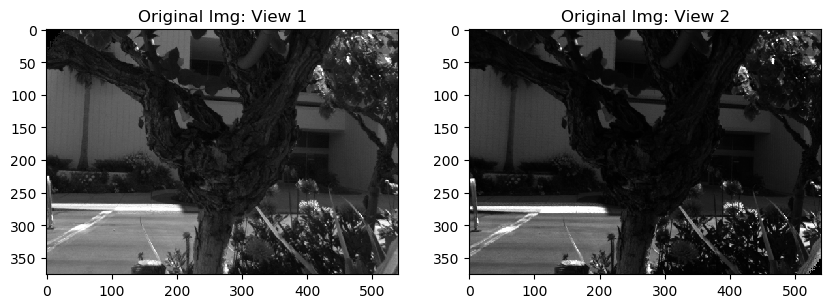

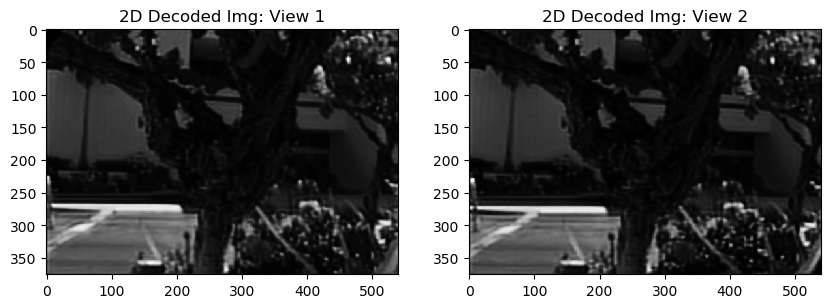

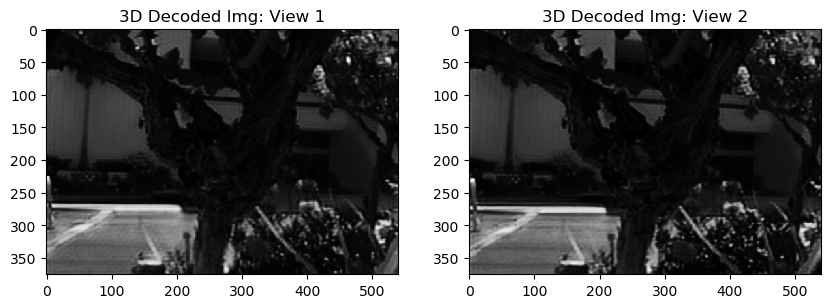

In [14]:
gamma = 1
plot_LF('Original Img', test_img4D, (2,2), (11,11), 0.7)
plot_LF('2D Decoded Img', decoded2D_img4D, (2,2), (11,11), gamma)
plot_LF('3D Decoded Img', decoded3D_img4D, (2,2), (11,11), gamma)

v = (2,2)

# Mean Squared Error
mse = np.mean((test_img4D - decoded2D_img4D)**2)
sim = compare_ssim(test_img4D[:,:,v[0], v[1]], decoded2D_img4D[:,:,v[0], v[1]], data_range=1)
psnr = -10*np.log10(mse)
print('2D Mean Squared Error: %0.3f %%' % (mse*100))
print('2D Decoded PSNR: %0.3f dB' % (psnr))
print('2D SSIM: %0.3f %%' % (sim*100))
mse = np.mean((test_img4D - decoded3D_img4D)**2)
sim = compare_ssim(test_img4D[:,:,v[0], v[1]], decoded3D_img4D[:,:,v[0], v[1]], data_range=1)
psnr = -10*np.log10(mse)
print('3D Mean Squared Error: %0.3f %%' % (mse*100))
print('3D Decoded PSNR: %0.3f dB' % (psnr))
print('3D SSIM: %0.3f %%' % (sim*100))

### Quick test of denoising capabilities

In [21]:
mean = 0
sigma = 0.3;
noise_array = np.ndarray(shape=test_img4D.shape)
test_img4D_noisy = np.clip(test_img4D + cv2.randn(noise_array, mean, sigma), 0,1).astype(np.float32)

In [16]:
decoded2D_img4D_noisy = np.clip(decode_2DLF(test_img4D_noisy, model2D),0,1)
decoded3D_img4D_noisy = np.clip(decode_3DLF(test_img4D_noisy, model3D),0,1)

/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/scipy/misc/pilutil.py:217: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, channel_axis=2)
/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/scipy/misc/pilutil.py:336: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  cmin=cmin, cmax=cmax)


Original SSIM: 8.24 
Original Mean Squared Error: 5.127 %
Original PSNR: 12.902 dB
2D Decoded SSIM: 35.11 
2D Decoded Mean Squared Error: 1.071 %
2D Decoded PSNR: 19.701 dB
3D Decoded SSIM: 57.07 
3D Decoded Mean Squared Error: 0.667 %
3D Decoded PSNR: 21.759 dB
14-Acerage SSIM: 23.91 
14-Average Mean Squared Error: 1.804 %
14-Average PSNR: 17.437 dB
14Noise SSIM: 34.08 
14Noise Mean Squared Error: 0.534 %
14Noise PSNR: 22.721 dB


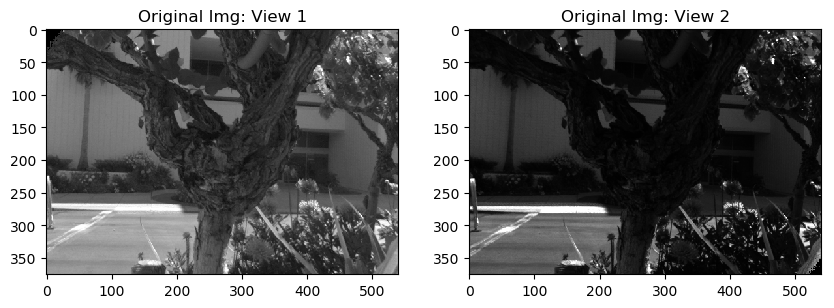

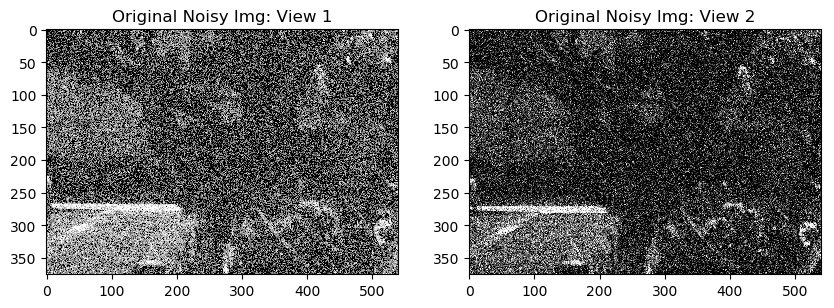

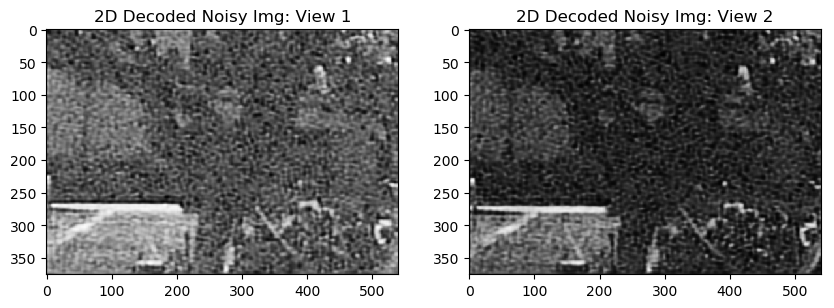

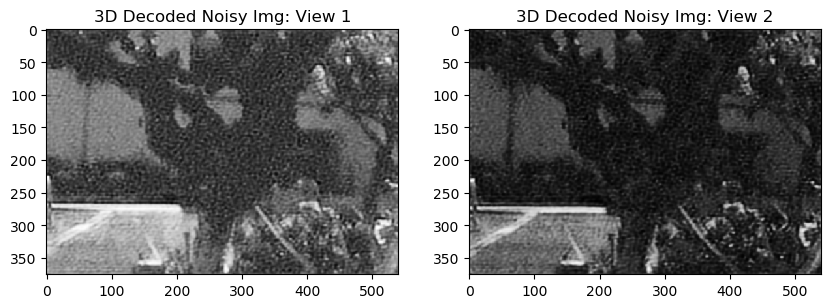

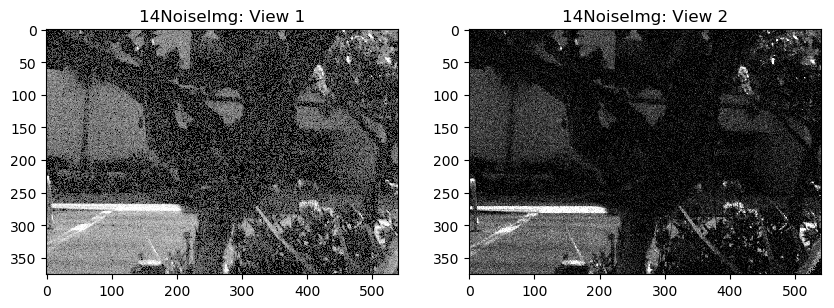

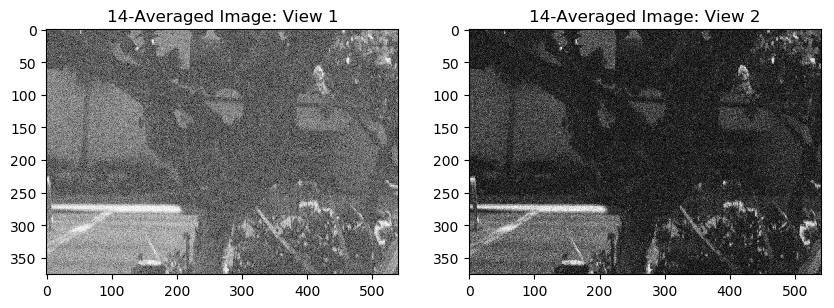

In [23]:
gamma = 0.5
plot_LF('Original Img', test_img4D, (2,2), (11,11), gamma)
plot_LF('Original Noisy Img', test_img4D_noisy, (2,2), (11,11), gamma)
plot_LF('2D Decoded Noisy Img', decoded2D_img4D_noisy, (2,2), (11,11), gamma)
plot_LF('3D Decoded Noisy Img', decoded3D_img4D_noisy, (2,2), (11,11), gamma)

avg_img = np.mean(test_img4D_noisy[:,:,1:12,:], 2)
avg_img4D = np.tile(avg_img, (14,1,1,1))
avg_img4D = np.transpose(avg_img4D, (1,2,0,3))
plot_LF('14-Averaged Image', avg_img4D, (2,2), (11,11), gamma)

# save images

img_orig = get_center_view(test_img4D, gamma)
img_noisy = get_center_view(test_img4D_noisy, gamma)
img_avg = get_center_view(avg_img4D, gamma)
img_2D = get_center_view(decoded2D_img4D_noisy, gamma)
img_3D = get_center_view(decoded3D_img4D_noisy, gamma)

scipy.misc.imsave("images/Original.png", img_orig)
scipy.misc.imsave("images/Noisy.png", img_noisy)
scipy.misc.imsave("images/14-AVG.png", img_avg)
scipy.misc.imsave("images/2D_CNN.png", img_2D)
scipy.misc.imsave("images/3D_CNN.png", img_3D)


v = (3,3)
# MSE/PSNR/ssim comparison
mse = np.mean((test_img4D - test_img4D_noisy)**2)
psnr = -10*np.log10(mse)
ssim = compare_ssim(test_img4D[:,:,v[0], v[1]], test_img4D_noisy[:,:,v[0], v[1]], data_range=1)
print('Original SSIM: %0.2f ' % (ssim*100))
print('Original Mean Squared Error: %0.3f %%' % (mse*100))
print('Original PSNR: %0.3f dB' % (psnr))
mse = np.mean((test_img4D - decoded2D_img4D_noisy)**2)
psnr = -10*np.log10(mse)
ssim = compare_ssim(test_img4D[:,:,v[0], v[1]], decoded2D_img4D_noisy[:,:,v[0], v[1]], data_range=1)
print('2D Decoded SSIM: %0.2f ' % (ssim*100))
print('2D Decoded Mean Squared Error: %0.3f %%' % (mse*100))
print('2D Decoded PSNR: %0.3f dB' % (psnr))
mse = np.mean((test_img4D - decoded3D_img4D_noisy)**2)
psnr = -10*np.log10(mse)
ssim = compare_ssim(test_img4D[:,:,v[0], v[1]], decoded3D_img4D_noisy[:,:,v[0], v[1]], data_range=1)
print('3D Decoded SSIM: %0.2f ' % (ssim*100))
print('3D Decoded Mean Squared Error: %0.3f %%' % (mse*100))
print('3D Decoded PSNR: %0.3f dB' % (psnr))
# MSE to not noisy image
mse = np.mean((test_img4D - avg_img4D)**2)
psnr = -10*np.log10(mse)
ssim = compare_ssim(test_img4D[:,:,v[0], v[1]], avg_img4D[:,:,v[0], v[1]], data_range=1)
print('14-Acerage SSIM: %0.2f ' % (ssim*100))
print('14-Average Mean Squared Error: %0.3f %%' % (mse*100))
print('14-Average PSNR: %0.3f dB' % (psnr))
# MSE to not noisy image
mse = np.mean((test_img4D - test_img4D_14noise)**2)
psnr = -10*np.log10(mse)
ssim = compare_ssim(test_img4D[:,:,v[0], v[1]], test_img4D_14noise[:,:,v[0], v[1]], data_range=1)
print('14Noise SSIM: %0.2f ' % (ssim*100))
print('14Noise Mean Squared Error: %0.3f %%' % (mse*100))
print('14Noise PSNR: %0.3f dB' % (psnr))

In [50]:
test_img4D_noisy.dtype

dtype('float32')

In [51]:
v = (3,3)
print(compare_ssim(test_img4D[:,:,v[0], v[1]], decoded2D_img4D_noisy[:,:,v[0], v[1]], data_range=1))
print(compare_ssim(test_img4D[:,:,v[0], v[1]], decoded3D_img4D_noisy[:,:,v[0], v[1]], data_range=1))

0.3577399574295918
0.5727223078700069


### Analytics on denoising capabilities
### New Model (v2)

In [52]:
test_img4D = get_image(180)

You specified a test image!


### MSE

In [53]:
model2D.load_weights('weights2D_v2.h5')
model3D.load_weights('weights3D_v2.h5')
sigma = np.logspace(-1.5, 0, 4, base=10)
ssim = get_err_over_noise(sigma, test_img4D, model2D, model3D, method='mse')

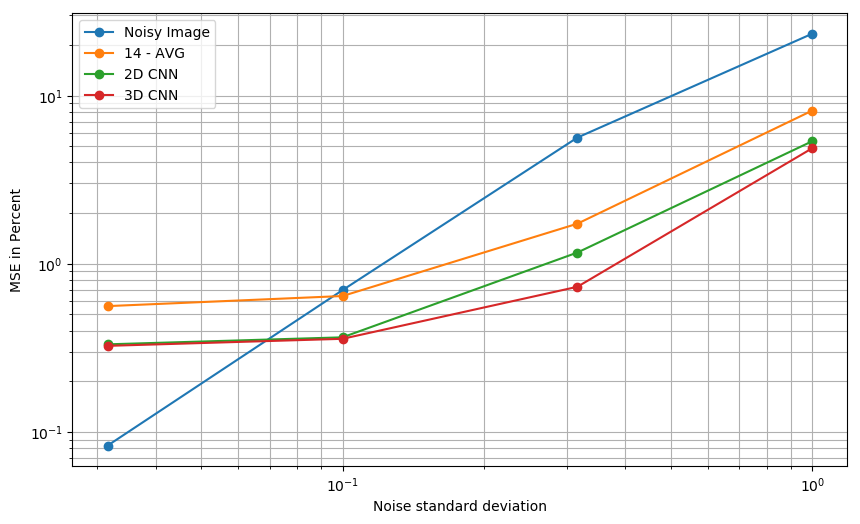

In [54]:
plot_graph(sigma, ssim, label='MSE')

### SSIM

In [55]:
ssim = get_err_over_noise(sigma, test_img4D, model2D, model3D, method='ssim')

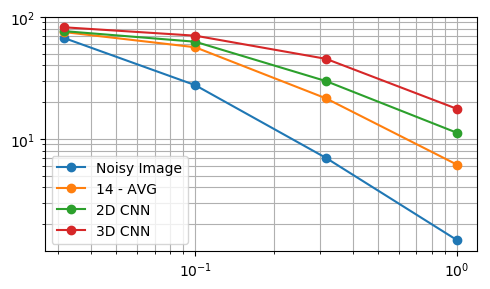

In [63]:
plot_graph(sigma, ssim, label='SSIM', figsize=(5,3))
plt.tight_layout()
plt.savefig("images/aenc_v2_plot_nolabel.pdf", dpi=300)

### Old Model

In [57]:
model2D_old = load_model('../aenc_v1/test_2Daenc.h5')
model2D_old.load_weights('../aenc_v1/weights2D.h5')
model3D_old = load_model('../aenc_v1/test_3Daenc.h5')
model3D_old.load_weights('../aenc_v1/weights3D.h5')

/home/sci/anaconda2/envs/autoencoder/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:509: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


#### MSE

In [58]:
sigma = np.logspace(-1.5, 0, 4, base=10)
ssim_old = get_err_over_noise(sigma, test_img4D, model2D_old, model3D_old, method='mse')
plot_graph(sigma, ssim_old, label='MSE')

KeyboardInterrupt: 

#### SSIM

In [ ]:
sigma = np.logspace(-1.5, 0, 4, base=10)
ssim_old = get_err_over_noise(sigma, test_img4D, model2D_old, model3D_old, method='ssim')
plot_graph(sigma, ssim_old, label='SSIM')